# *R-group decomposition*

Em quiminformática é muito comum trabalhar com conjuntos de dados de moléculas que compartilham uma mesma subestrutura. Em geral, essa é uma subestrutura central, que também podemos chamar de *scaffold*. A essa subestrutura estão ligados grupos distintos em uma ou mais posições - esses grupos são chamados genericamente de *R-groups*.

Vamos ver neste Notebook como destacar os *R-groups* de um conjunto de estruturas que compartilham o mesmo *scaffold*. Este Notebook é uma continuação do [Destacando subestruturas com o RDKit](https://github.com/rflameiro/Python_e_Quiminformatica/blob/main/Quiminformatica/Destacando%20subestruturas%20com%20o%20RDKit.ipynb).

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../datasets/antibiotics_SMILES.csv')
df.head()

,name,class,SMILES
0,Amikacin,aminoglycosides,NCC[C@H](O)C(=O)N[C@@H]1C[C@H](N)[C@@H](O[C@H]...
1,Gentamicin,aminoglycosides,CNC(C)C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(NC...
2,Kanamycin,aminoglycosides,NC[C@H]1O[C@H](O[C@@H]2[C@@H](N)C[C@@H](N)[C@H...
3,Neomycin,aminoglycosides,NC[C@@H]1O[C@H](O[C@@H]2[C@@H](CO)O[C@@H](O[C@...
4,Netilmicin,aminoglycosides,CCN[C@@H]1C[C@H](N)[C@@H](O[C@H]2OC(CN)=CC[C@H...


In [3]:
# Classes e número de compostos em cada uma
df['class'].value_counts()

quinolones/fluoroquinolones    18
penicillins                    16
others                         11
mycobacteria                   11
cephalosporins3                11
sulfonamides                   10
aminoglycosides                 9
cephalosporins2                 9
carbapenem                      7
macrolides                      7
cephalosporins1                 6
tetracyclines                   6
glycopeptides                   5
oxazolidinones                  4
ansamycins                      3
cephalosporins4                 3
cephalosporins5                 2
lincosamides                    2
nitrofurans                     2
polypeptides                    2
lipopeptides                    1
monobactams                     1
Name: class, dtype: int64

Aqui importamos os módulos necessários para trabalhar com os *R-groups* (`RDKit`) e gerar as imagens no Jupyter Notebook.

In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize=(450,350)
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdqueries
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Geometry
rdDepictor.SetPreferCoordGen(True)

from IPython.display import SVG,Image
from ipywidgets import interact

import rdkit
print(rdkit.__version__)

2022.03.3


Vamos explorar a variedade de substituintes dos antibióticos beta-lactâmicos marcados como "cephalosporins1".

In [5]:
df_1 = df[df['class']=='cephalosporins1']
df_1.head()

,name,class,SMILES
19,Cefadroxil,cephalosporins1,CC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@H](N)c3ccc...
20,Cefalexin,cephalosporins1,CC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@H](N)c3ccc...
21,Cefazolin,cephalosporins1,Cc1nnc(SCC2=C(C(=O)O)N3C(=O)[C@@H](NC(=O)Cn4cn...
22,Cephradine,cephalosporins1,CC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@H](N)C3=CC...
23,Cephapirin,cephalosporins1,CC(=O)OCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)CSc3cc...


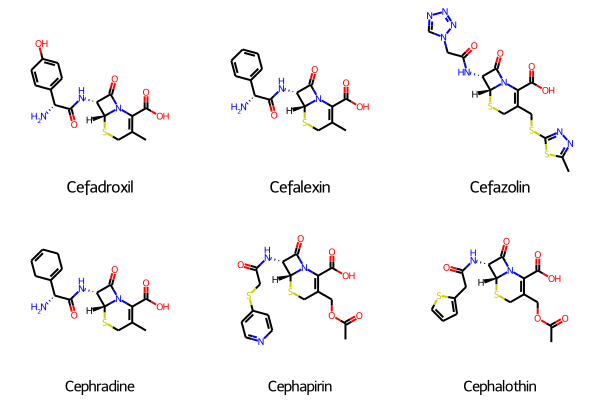

In [6]:
# Gerar RDKit Mol
smis = df_1['SMILES']
names = list(df_1.name)
ms = [Chem.MolFromSmiles(x) for x in smis]

# Desenhar estruturas
for m in ms:
    rdDepictor.Compute2DCoords(m)
Draw.MolsToGridImage(ms[:12],legends=names,molsPerRow=3)

Esta parte é um pouco mais chata: tive que copiar o SMILES de uma das estruturas e colar no ChemDraw, remover os grupos nas posições que quis deixar "abertas" (as posições dos *R-groups*) e substituí por asteriscos. Depois, adicionei manualmente a numeração nos asteriscos para definir as posições (no caso, apenas 1 e 2, mas podem existir mais pontos de substituição em séries diferentes).

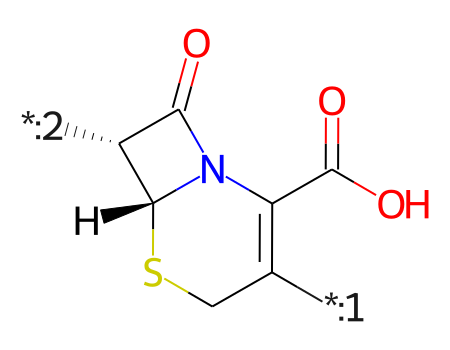

In [7]:
# Definir o scaffold, ou core
# O SMILES vem assim do ChemDraw:
# '[*]C1=C(N2C([C@H]([C@H]2SC1)[*])=O)C(O)=O'
# Apenas adicionei a numeração aos asteriscos - [*:1] e [*:2]
core_smiles = '[*:1]C1=C(N2C([C@H]([C@H]2SC1)[*:2])=O)C(O)=O'
core = Chem.MolFromSmiles(core_smiles)
rdDepictor.SetPreferCoordGen(True)
rdDepictor.Compute2DCoords(core)

core

Some pre-processing work we need to do:

convert the dummy atoms in the scaffold into query atoms that match anything
add hydrogens to the molecules
select only the subset of molecules which match the core
set a property on each atom which is used to track its original index (we use this later in the RGD analysis)

Agora, vamos ao pré-processamento do core:

- Convertemos os átomos fictícios no *scaffold* (*) em átomos "query", que podem corresponder a qualquer coisa
- Adicionamos hidrogênios às moléculas
- Selecionamos apenas o subconjunto de moléculas que apresentam o *core* definido
- Definimos uma propriedade em cada átomo que é usada para rastrear seu índice original (usaremos isso mais tarde na análise RGD)

In [8]:
ps = Chem.AdjustQueryParameters.NoAdjustments()
ps.makeDummiesQueries=True

qcore = Chem.AdjustQueryProperties(core,ps)
mhs = [Chem.AddHs(x, addCoords=True) for x in ms]  # número de compostos da série
mms = [x for x in mhs if x.HasSubstructMatch(qcore)] # compostos que batem com o core

for m in mms:
    for atom in m.GetAtoms():
        atom.SetIntProp("SourceAtomIdx", atom.GetIdx())
print(len(mhs),len(mms))

6 6


Todos os seis compostos selecionados apresentam o *core* definido.

O código abaixo faz a análise RGD (*R-Group Decomposition*), ou seja, identifica os substituintes que "enfeitam" o *core* para cada molécula da série.

In [9]:
# RGD
rdkit.RDLogger.DisableLog('rdApp.warning')
groups,_ = rdRGroupDecomposition.RGroupDecompose([qcore], mms, asSmiles=False, asRows=True)

A extensa função definida abaixo gera coordenadas alinhadas e cria a imagem com os grupos R destacados.

Não vou entrar em detalhes sobre o que cada parte da função faz, mas acho relevante comentar que a seção que define as listas de cores (`colors`) apresenta três opções diferentes, das quais você pode escolher uma. Para isso, basta adicionar `#` na frente das listas que não quer usar. No exemplo abaixo, removi as listas Tol e IBM, para usar a lista Okabe_Ito.

In [10]:
from collections import defaultdict

def highlight_rgroups(mol,row,core,width=350,height=200,
                      fillRings=True,legend="",
                      sourceIdxProperty="SourceAtomIdx",
                      lbls=('R1','R2','R3','R4')):
    # copy the molecule and core
    mol = Chem.Mol(mol)
    core = Chem.Mol(core)

    # -------------------------------------------
    # include the atom map numbers in the substructure search in order to 
    # try to ensure a good alignment of the molecule to symmetric cores
    for at in core.GetAtoms():
        if at.GetAtomMapNum():
            at.ExpandQuery(rdqueries.IsotopeEqualsQueryAtom(200+at.GetAtomMapNum()))
            
    for lbl in row:
        if lbl=='Core':
            continue
        rg = row[lbl]
        for at in rg.GetAtoms():
            if not at.GetAtomicNum() and at.GetAtomMapNum() and \
            at.HasProp('dummyLabel') and at.GetProp('dummyLabel')==lbl:
                # attachment point. the atoms connected to this
                # should be from the molecule
                for nbr in at.GetNeighbors():
                    if nbr.HasProp(sourceIdxProperty):
                        mAt = mol.GetAtomWithIdx(nbr.GetIntProp(sourceIdxProperty))
                        if mAt.GetIsotope():
                            mAt.SetIntProp('_OrigIsotope',mAt.GetIsotope())
                        mAt.SetIsotope(200+at.GetAtomMapNum())
    # remove unmapped hs so that they don't mess up the depiction
    rhps = Chem.RemoveHsParameters()
    rhps.removeMapped = False
    tmol = Chem.RemoveHs(mol,rhps)
    rdDepictor.GenerateDepictionMatching2DStructure(tmol,core)

    oldNewAtomMap={}
    # reset the original isotope values and account for the fact that
    # removing the Hs changed atom indices
    for i,at in enumerate(tmol.GetAtoms()):
        if at.HasProp(sourceIdxProperty):
            oldNewAtomMap[at.GetIntProp(sourceIdxProperty)] = i
            if at.HasProp("_OrigIsotope"):
                at.SetIsotope(at.GetIntProp("_OrigIsotope"))
                at.ClearProp("_OrigIsotope")
            else:
                at.SetIsotope(0)
      
    # ------------------
    #  set up our colormap
    #   the three choices here are all "colorblind" colormaps
    
    # "Tol" colormap from https://davidmathlogic.com/colorblind
    # colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(136,34,85)]
    # "IBM" colormap from https://davidmathlogic.com/colorblind
    # colors = [(100,143,255),(120,94,240),(220,38,127),(254,97,0),(255,176,0)]
    # Okabe_Ito colormap from https://jfly.uni-koeln.de/color/
    colors = [(230,159,0),(86,180,233),(0,158,115),(240,228,66),(0,114,178),(213,94,0),(204,121,167)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
  
    #----------------------
    # Identify and store which atoms, bonds, and rings we'll be highlighting
    highlightatoms = defaultdict(list)
    highlightbonds = defaultdict(list)
    atomrads = {}
    widthmults = {}

    rings = []
    for i,lbl in enumerate(lbls):    
        color = colors[i%len(colors)]
        rquery = row[lbl]
        Chem.GetSSSR(rquery)
        rinfo = rquery.GetRingInfo()
        for at in rquery.GetAtoms():
            if at.HasProp(sourceIdxProperty):
                origIdx = oldNewAtomMap[at.GetIntProp(sourceIdxProperty)]
                highlightatoms[origIdx].append(color)
                atomrads[origIdx] = 0.4
        if fillRings:
            for aring in rinfo.AtomRings():
                tring = []
                allFound = True
                for aid in aring:
                    at = rquery.GetAtomWithIdx(aid)
                    if not at.HasProp(sourceIdxProperty):
                        allFound = False
                        break
                    tring.append(oldNewAtomMap[at.GetIntProp(sourceIdxProperty)])
                if allFound:
                    rings.append((tring,color))
        for qbnd in rquery.GetBonds():
            batom = qbnd.GetBeginAtom()
            eatom = qbnd.GetEndAtom()
            if batom.HasProp(sourceIdxProperty) and eatom.HasProp(sourceIdxProperty):
                origBnd = tmol.GetBondBetweenAtoms(oldNewAtomMap[batom.GetIntProp(sourceIdxProperty)],
                                                 oldNewAtomMap[eatom.GetIntProp(sourceIdxProperty)])
                bndIdx = origBnd.GetIdx()
                highlightbonds[bndIdx].append(color)
                widthmults[bndIdx] = 2

    d2d = rdMolDraw2D.MolDraw2DCairo(width,height)
    dos = d2d.drawOptions()
    dos.useBWAtomPalette()
                
    #----------------------
    # if we are filling rings, go ahead and do that first so that we draw
    # the molecule on top of the filled rings
    if fillRings and rings:
        # a hack to set the molecule scale
        d2d.DrawMoleculeWithHighlights(tmol,legend,dict(highlightatoms),
                                       dict(highlightbonds),
                                       atomrads,widthmults)
        d2d.ClearDrawing()
        conf = tmol.GetConformer()
        for (aring,color) in rings:
            ps = []
            for aidx in aring:
                pos = Geometry.Point2D(conf.GetAtomPosition(aidx))
                ps.append(pos)
            d2d.SetFillPolys(True)
            d2d.SetColour(color)
            d2d.DrawPolygon(ps)
        dos.clearBackground = False

    #----------------------
    # now draw the molecule, with highlights:
    d2d.DrawMoleculeWithHighlights(tmol,legend,dict(highlightatoms),dict(highlightbonds),
                                   atomrads,widthmults)
    d2d.FinishDrawing()
    png = d2d.GetDrawingText()
    return png

A função abaixo usa código interativo, que não aparece no GitHub, mas funciona se o Notebook for usado localmente.

In [11]:
# Visualizar moléculas uma a uma de forma interativa

@interact(idx=range(0,len(ms)))
def draw_it(idx=0):
    m = mms[idx]
    row = groups[idx]
    return Image(highlight_rgroups(m,row,qcore,lbls=('R1','R2')))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5), value=0), Output()), _dom_classe…

Por enquanto, a função `DrawMolsToGridImage()` do `RDKit` não suporta o *highlight* em múltiplas estruturas. Portanto, o autor escreveu uma função para combinar manualmente as imagens, usando o pacote `pillow`.

In [12]:
from PIL import Image as pilImage
from io import BytesIO

def draw_multiple(ms,groups,qcore,lbls,legends=None,nPerRow=4,subImageSize=(250,200)):
    nRows = len(ms)//nPerRow
    if len(ms)%nPerRow:
        nRows+=1
    nCols = nPerRow
    imgSize = (subImageSize[0]*nCols,subImageSize[1]*nRows)
    res = pilImage.new('RGB',imgSize)
    
    for i,m in enumerate(ms):
        col = i%nPerRow
        row = i//nPerRow
        if legends:
            legend = legends[i]
        else:
            legend = ''
        png = highlight_rgroups(m,groups[i],qcore,lbls=lbls,legend=legend,
                               width=subImageSize[0],height=subImageSize[1])
        bio = BytesIO(png)
        img = pilImage.open(bio)
        res.paste(img,box=(col*subImageSize[0],row*subImageSize[1]))
    bio = BytesIO()
    res.save(bio,format='PNG')
    return bio.getvalue()

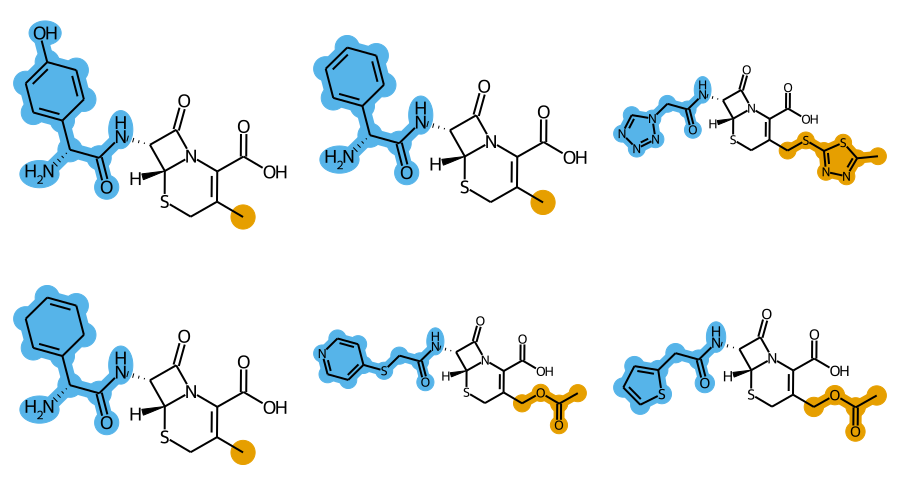

In [13]:
Image(draw_multiple(mms, groups, qcore, ('R1','R2'), nPerRow=3, subImageSize=(300,250)))

Podemos também adicionar legendas às imagens geradas pelas funções `highlight_rgroups` e `draw_multiple`:

In [14]:
names = list(df_1.name)

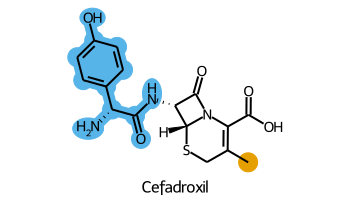

In [15]:
i = 0
Image(highlight_rgroups(mms[i], groups[i], qcore, lbls=('R1','R2'), legend=names[i]))

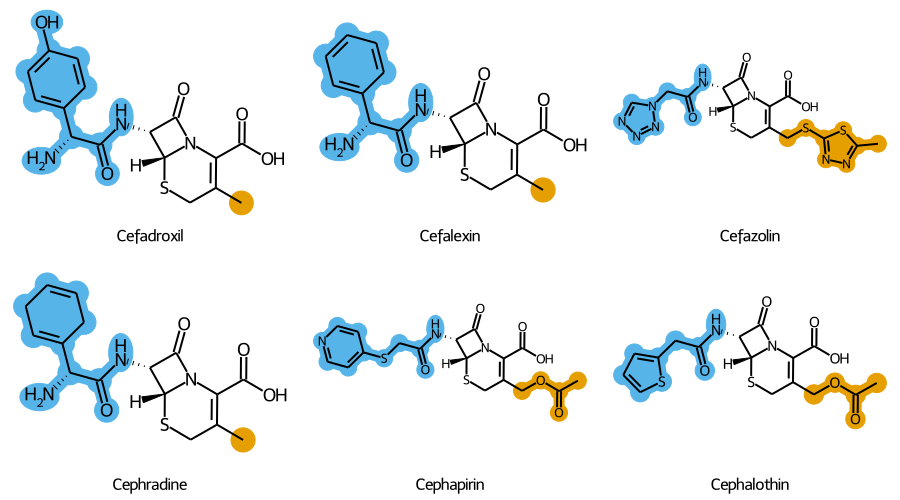

In [16]:
Image(draw_multiple(mms, groups, qcore, ('R1','R2'), nPerRow=3, subImageSize=(300,250), legends=names))

# Fontes usadas

- http://rdkit.blogspot.com/2020/10/
- https://www.rdkit.org/docs/Cookbook.html